## Error and Correlation from all 3 models for top 50 images

In [1]:
# ## Uncomment if using Google Colab and upload file dataTop50.xlsx
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
# Initialize these:
# typeImg = "top" # photo/ cartoon/ all"
# numImg = "50" # 5 or 50
# sz = 100
filepath = 'dataTop50.xlsx'
filepath2 = 'dataTop50_181_186.xlsx'
strtInd = [0, 2900, 5800, 8700, 11600, 14500, 17400, 20300, 23200, 26100, 29000, 31900, 34800]

In [3]:
 # Include imports
import glob
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
import os
import pandas as pd
import numpy as np
import skimage.color as skcolor
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
colNames = ["col_"+str(i) for i in range(58)] 
allConcepts = ['mango','watermelon','honeydew','cantaloupe','grapefruit','strawberry','raspberry','blueberry','avocado','orange','lime','lemon']

# Read data
# Get the color ratings data -From file data_clean.csv
data = pd.read_csv("data_clean.csv",names = colNames)

# Get the LAB coordinates of colors from file LabOrig.csv
#colorData = pd.read_csv("LabOrig.csv",header=None)
colorData = pd.read_csv("Lab.csv",header=None)
colorDataRGB = pd.read_csv("RGB.csv",header=None)
path = "E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads"
sz = 100

In [5]:
df = pd.read_excel(filepath)
Q = df.as_matrix()
Q.shape

(34800, 187)

In [6]:
df2 = pd.read_excel(filepath2,header=None)
Q2_init = df2.as_matrix()
Q2_init.shape

(34800, 6)

In [7]:
from sklearn.preprocessing import StandardScaler
Q2_scalar = StandardScaler()
Q2 = Q2_scalar.fit_transform(Q2_init)

In [8]:
X = np.column_stack([Q[:,:-1],Q2[:,:]])
y = np.copy(Q[:,-1])
print(X.shape)

# from sklearn.preprocessing import StandardScaler
# X_scalar = StandardScaler()
# X = X_scalar.fit_transform(Xt)
# print(X.shape, y.shape)

# y_scalar = StandardScaler()
# y = y_scalar.fit_transform(yt[:, None])[:, 0]
# y.shape

(34800, 192)


In [9]:
# X = np.copy(Q[:,:-1])
# y = np.copy(Q[:,-1])
# print(X.shape, y.shape)

In [10]:
# Function to computer error, correlation and rating for LOO fruit category 
# based on the features selected from Analysis (sparse regression)
from scipy import stats
        
def getRatings(minErrFeature):
    win0 = []
    win1 = []
    win2 = []
    xNew = np.column_stack([X[:,minErrFeature],y])
    correlation = []
    error = []

    # Linear Regression using Cross Validation
    # Leave one out cross validation -- strtInd holds the starting indices of set of fruit data 
    xTemp = np.copy(xNew)

    for i in range(len(strtInd)-1):
        # Leave one entire fruit group
        testFruit =  allConcepts[i]
        print("\nLeaving out fruit group : ",allConcepts[i])
        testTemp = np.copy(xTemp[strtInd[i]:strtInd[i+1],:]) # Get all rows from the LOO group
        trainTemp = np.delete(xTemp,range(strtInd[i],strtInd[i+1]),0)
        row = len(trainTemp)
        #Training set
        X_train = np.column_stack([np.ones((row,1)), trainTemp[:,:-1]]) # add offset
        y_train = np.copy(trainTemp[:,-1])
        # Test set (hold out set)
        row2 = len(testTemp)
        X_test  = np.column_stack([np.ones((row2,1)), testTemp[:,:-1]]) #xTemp[row:tot,0:3]#
        y_test  = np.copy(testTemp[:,-1])


        # Create linear regression object
        regr = linear_model.LinearRegression(fit_intercept=False)
        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        print("Score is : %.2f" % regr.score(X_test, y_test))
        # The coefficients
        print('Coefficients: ', regr.coef_)
        #print('Intercept: \n', regr.intercept_)
        # The mean squared error
        print("\nMean squared error: %.4f"
              % mean_squared_error(y_test, y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % r2_score(y_test, y_pred))

        ############## For test purposes - Average prediction over all Images of LOO group ############
        totalTestImages = y_pred.size/58  #58N rows -> every image has 58 rows of data
        avg_pred = [np.sum([y_pred[p] for p in range(q,y_pred.size,58)])/totalTestImages for q in range(58)]

        # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
        trueRating = np.copy(y_test[0:58])

        sqErr = np.sum(pow(avg_pred - trueRating,2))
        #print("The true squared error (in color ratings) for left out fruit",testFruit,"is: %.4f" % sqErr)

        corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
        print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
        #print("p-value %.4f" %pVal)

        error.append(sqErr)
        correlation.append(corrCoeff)
        win0.append(corrCoeff) # saves correlation for test fruit
        win1.append(trueRating) # saves true rating for test fruit
        win2.append(avg_pred)   # saves avg predicted rating for test fruit
        # Plot average color rating over all test images.
        fig= plt.figure(figsize=(10,3))
        barPlot = plt.bar(range(1,59), avg_pred,color = colorDataRGB.values)
        plt.ylabel('Ratings')
        plt.xlabel('Colors')
        plt.title('Predicted color ratings for Fruit Group : %s' %testFruit)
        plt.xticks([i for i in range(1,59,3)],[i for i in range(1,59,3)])
        plt.ylim(0,1)
        plt.show()

        fig= plt.figure(figsize=(10,3))
        barPlot = plt.bar(range(1,59), trueRating,color = colorDataRGB.values)
        plt.ylabel('Ratings')
        plt.xlabel('Colors')
        plt.title('True color ratings for Fruit Group : %s' %testFruit)
        plt.xticks([i for i in range(1,59,3)],[i for i in range(1,59,3)])
        plt.ylim(0,1)
        plt.show()

        # Scatter plot
        fig2 = plt.figure(figsize=(7,7))
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
        plt.ylabel('Predicted Ratings')
        plt.xlabel('Subject Ratings')
        plt.title('Scatter plot of color ratings for : %s' %testFruit)
        plt.axis('equal')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.show() 
    return error, correlation, win0, win1, win2

# Regression on top 3 spherical features


Leaving out fruit group :  mango
Score is : 0.45
Coefficients:  [ 0.17003133  0.30778784 -0.1665871   0.15168692]

Mean squared error: 0.0185
Variance score: 0.45

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9042


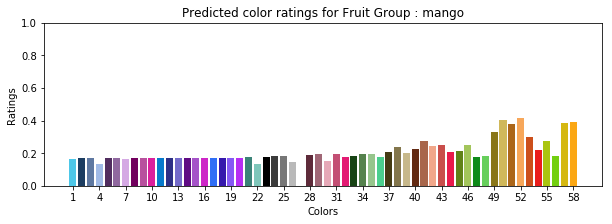

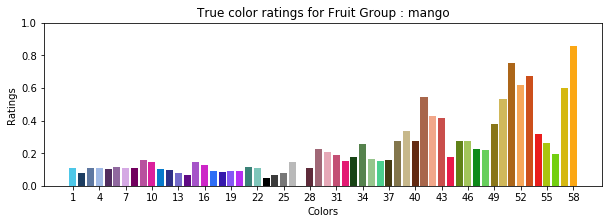

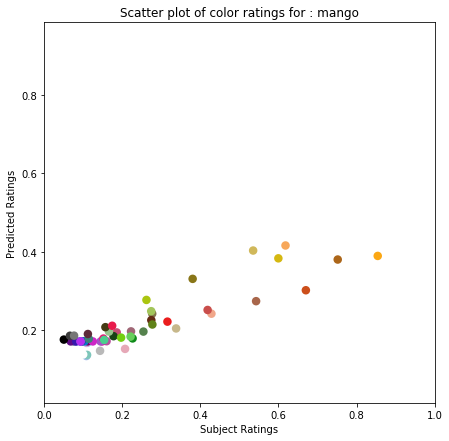


Leaving out fruit group :  watermelon
Score is : -0.03
Coefficients:  [ 0.16358978  0.32853486 -0.16646242  0.15829858]

Mean squared error: 0.0376
Variance score: -0.03

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4219


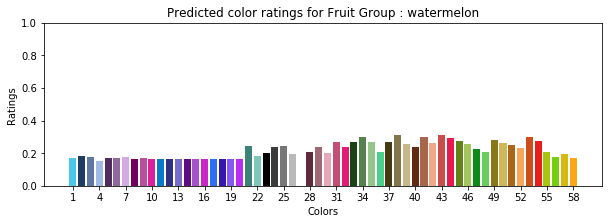

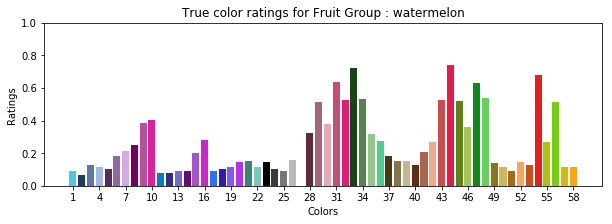

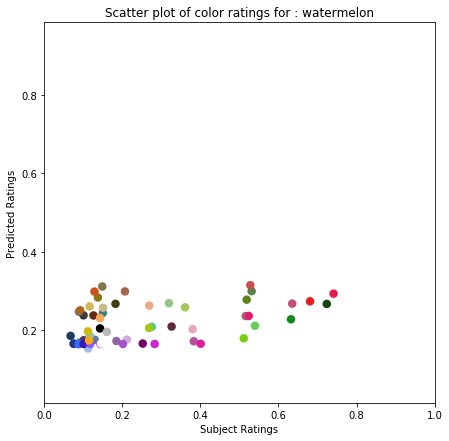


Leaving out fruit group :  honeydew
Score is : 0.35
Coefficients:  [ 0.16931325  0.33149935 -0.16929232  0.1509274 ]

Mean squared error: 0.0130
Variance score: 0.35

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7656


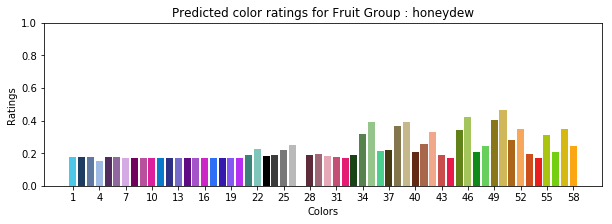

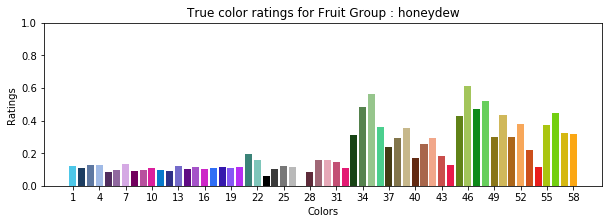

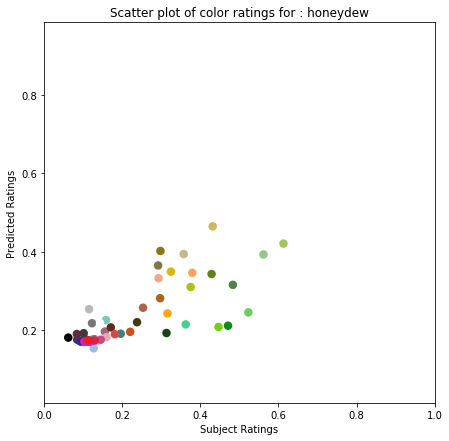


Leaving out fruit group :  cantaloupe
Score is : 0.46
Coefficients:  [ 0.17000581  0.31753073 -0.16239239  0.14787843]

Mean squared error: 0.0167
Variance score: 0.46

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8480


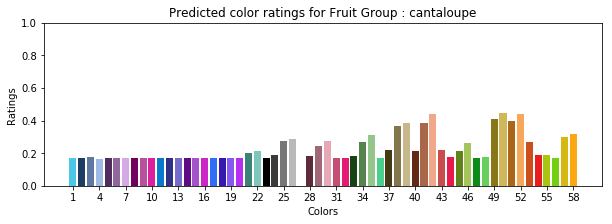

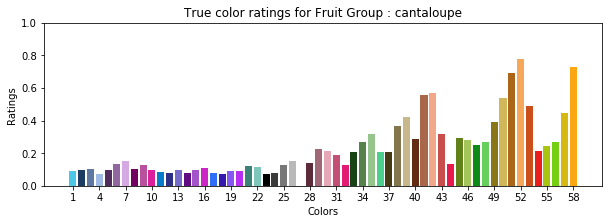

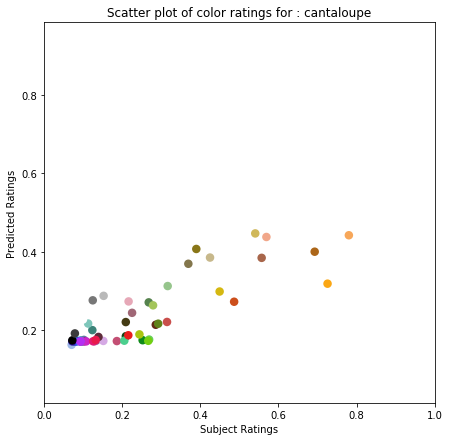


Leaving out fruit group :  grapefruit
Score is : 0.38
Coefficients:  [ 0.1677489   0.32320674 -0.16656188  0.14738571]

Mean squared error: 0.0152
Variance score: 0.38

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8536


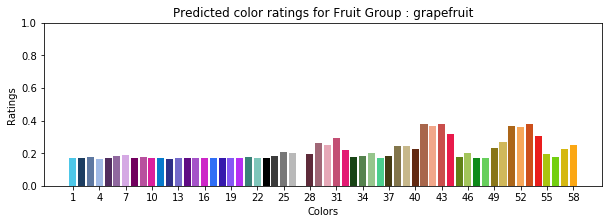

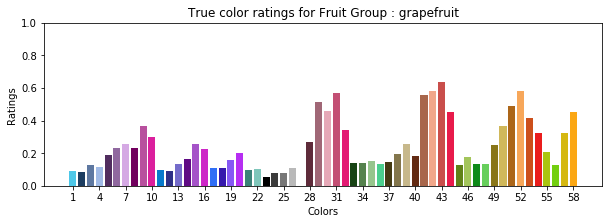

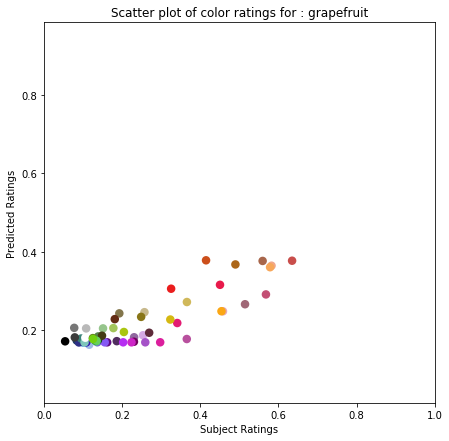


Leaving out fruit group :  strawberry
Score is : 0.10
Coefficients:  [ 0.1668636   0.32383963 -0.1643808   0.15818378]

Mean squared error: 0.0244
Variance score: 0.10

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4962


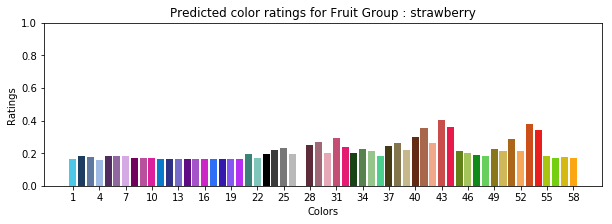

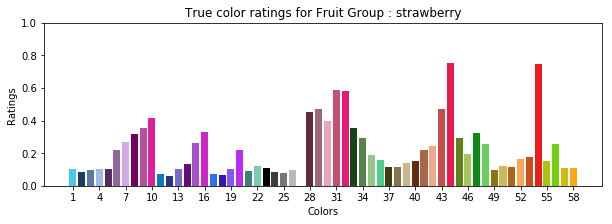

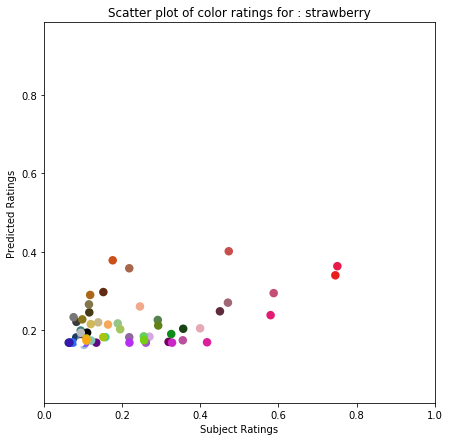


Leaving out fruit group :  raspberry
Score is : -0.18
Coefficients:  [ 0.16548182  0.33243624 -0.16616427  0.1676432 ]

Mean squared error: 0.0281
Variance score: -0.18

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.2686


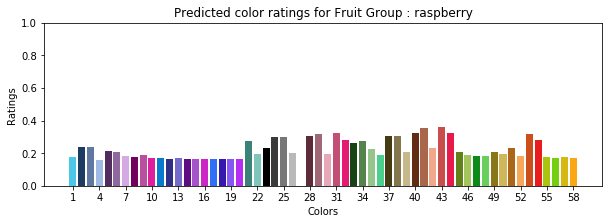

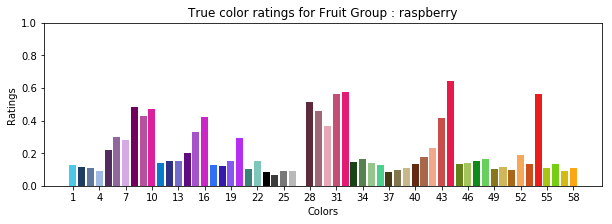

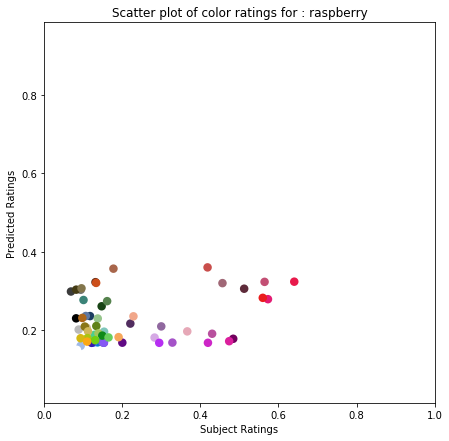


Leaving out fruit group :  blueberry
Score is : -0.01
Coefficients:  [ 0.16644823  0.32946184 -0.16214535  0.16176059]

Mean squared error: 0.0432
Variance score: -0.01

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.2661


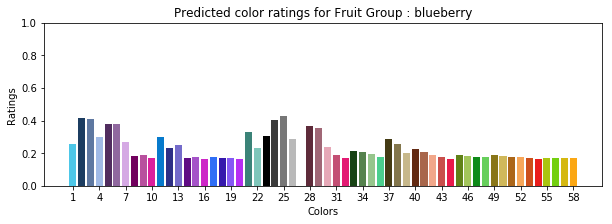

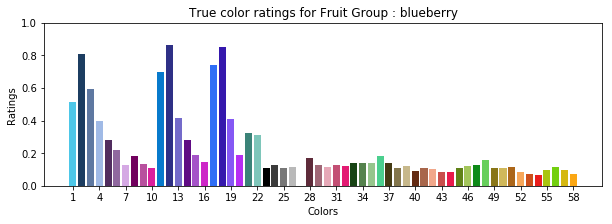

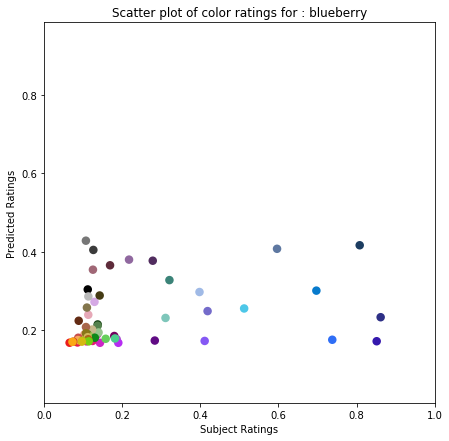


Leaving out fruit group :  avocado
Score is : 0.16
Coefficients:  [ 0.17125166  0.33609758 -0.16335894  0.13815634]

Mean squared error: 0.0301
Variance score: 0.16

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5291


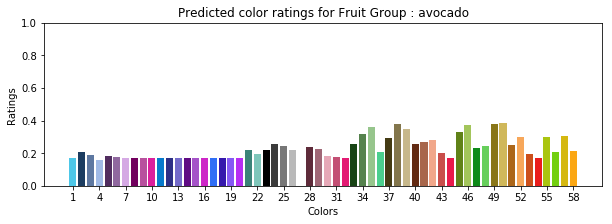

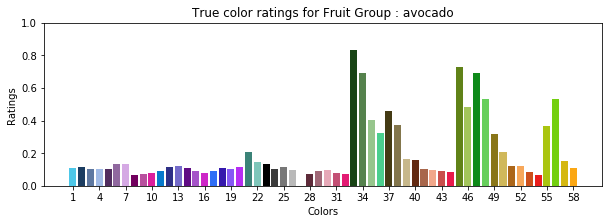

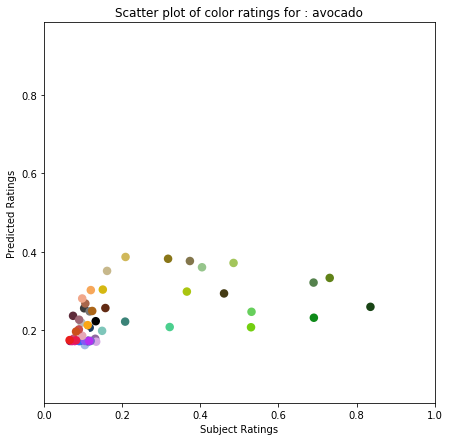


Leaving out fruit group :  orange
Score is : 0.44
Coefficients:  [ 0.17291214  0.31463155 -0.17818703  0.14725702]

Mean squared error: 0.0211
Variance score: 0.44

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9253


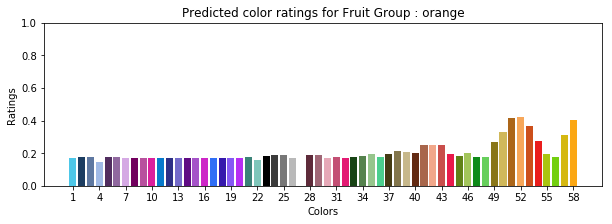

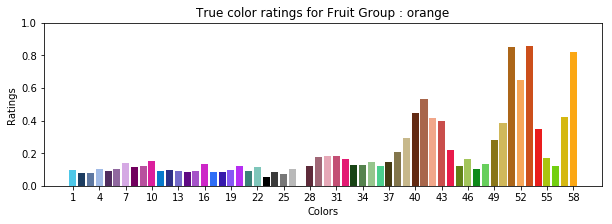

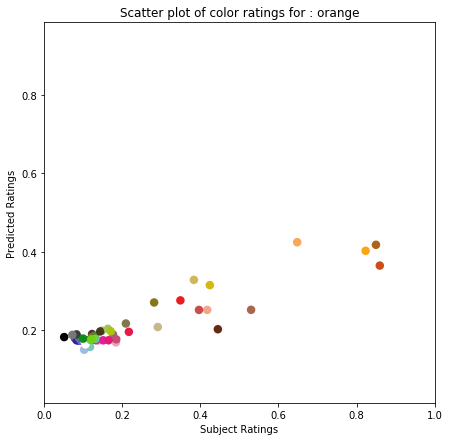


Leaving out fruit group :  lime
Score is : 0.30
Coefficients:  [ 0.17206359  0.33324914 -0.15828209  0.12996909]

Mean squared error: 0.0307
Variance score: 0.30

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7510


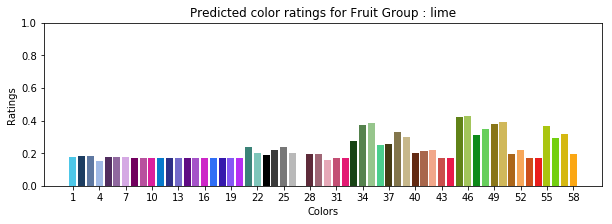

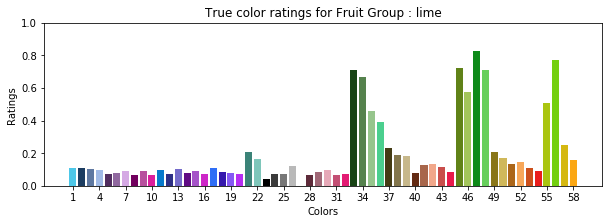

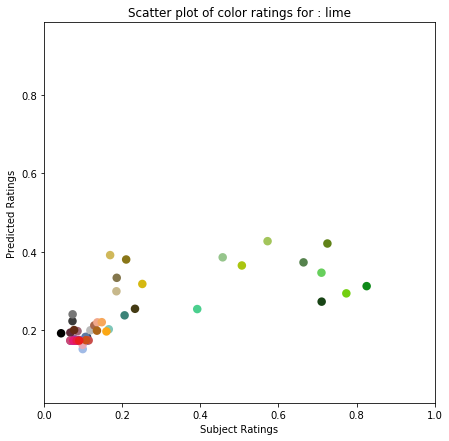


Leaving out fruit group :  lemon
Score is : 0.48
Coefficients:  [ 0.17324703  0.31402678 -0.16826265  0.15104488]

Mean squared error: 0.0135
Variance score: 0.48

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9185


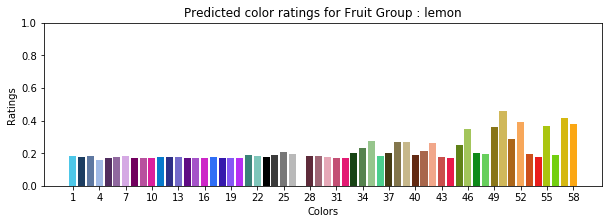

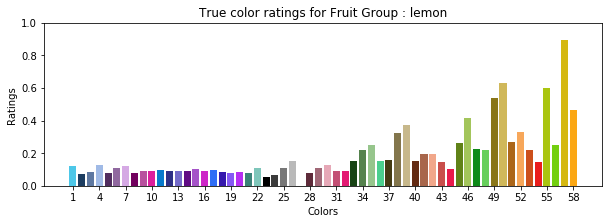

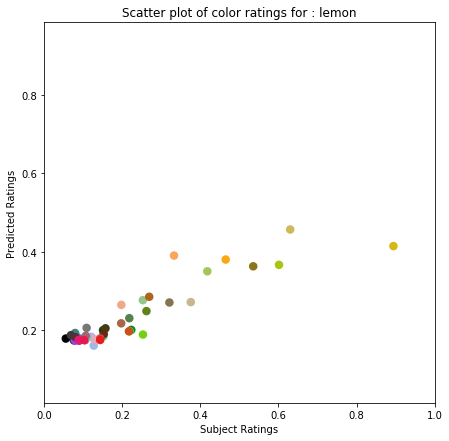

In [11]:
# Sparse features from Analysis I
minErrFeature1 = (4, 24, 29)
errSph, corrSph, win0_m1, win1_m1, win2_m1 = getRatings(minErrFeature1)

In [12]:
errSph

[0.9298740034723045,
 1.9182300358542779,
 0.5378211634232704,
 0.7624833019725957,
 0.6996933452773714,
 1.2276752571278013,
 1.302135733768031,
 2.3255004746674155,
 1.6104019663759899,
 1.0740603295819162,
 1.526278902065123,
 0.6244410292530058]

In [13]:
corrSph

[0.9041841974321773,
 0.4218707473960998,
 0.7656270991237777,
 0.8479862856291143,
 0.8535957881262379,
 0.4961878054011828,
 0.2686431325809553,
 0.26614046276740966,
 0.5290696378042566,
 0.9253425537892209,
 0.7510046207838849,
 0.9184923589643057]

# Regression on top 3 spherical + cyindrical features


Leaving out fruit group :  mango
Score is : 0.61
Coefficients:  [0.14186023 0.1588571  0.1164713  0.14244848]

Mean squared error: 0.0133
Variance score: 0.61

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9162


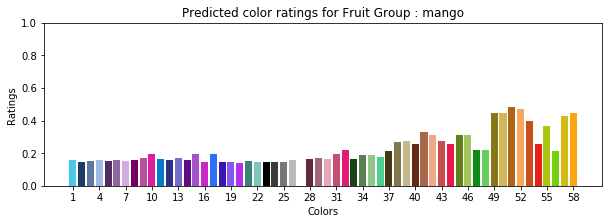

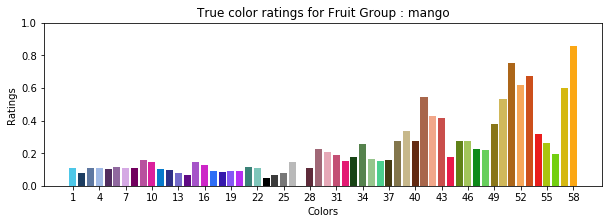

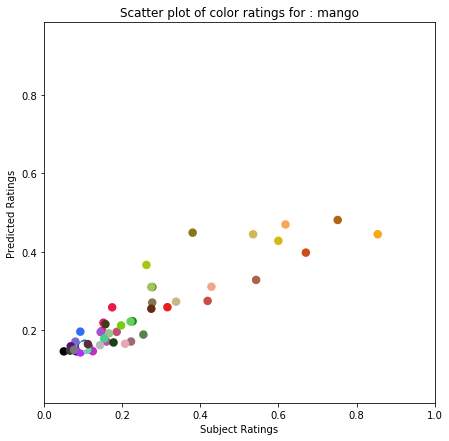


Leaving out fruit group :  watermelon
Score is : 0.02
Coefficients:  [0.13445806 0.18031026 0.10190949 0.15327321]

Mean squared error: 0.0358
Variance score: 0.02

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4778


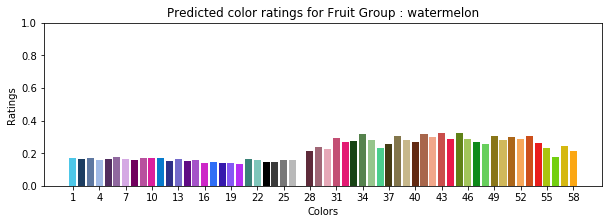

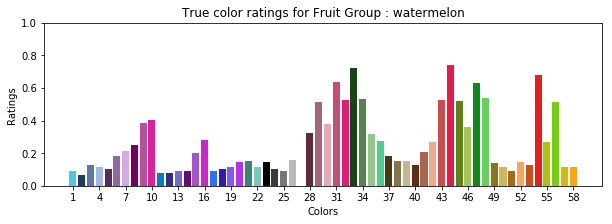

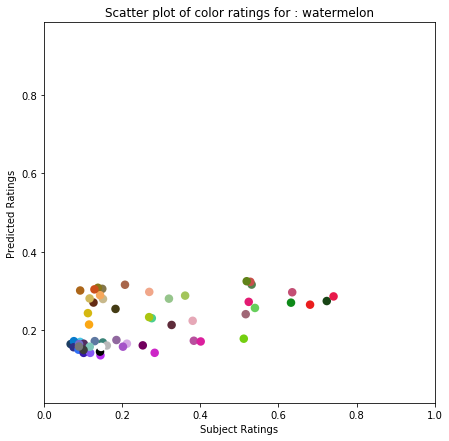


Leaving out fruit group :  honeydew
Score is : 0.47
Coefficients:  [0.13933527 0.15365937 0.15141578 0.1381719 ]

Mean squared error: 0.0106
Variance score: 0.47

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8111


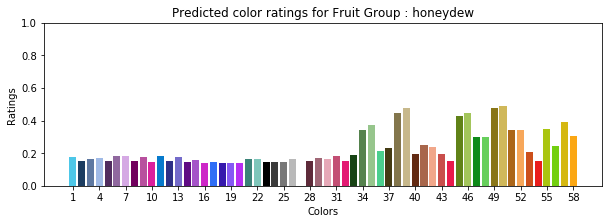

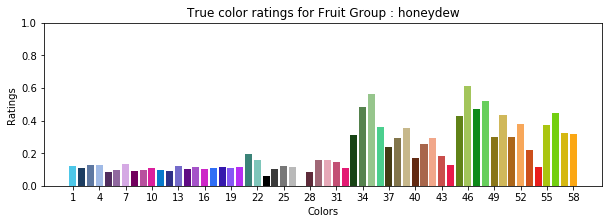

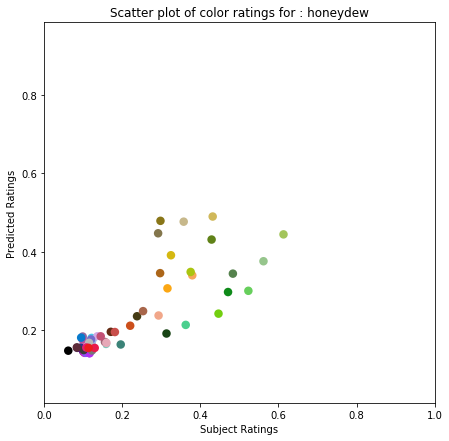


Leaving out fruit group :  cantaloupe
Score is : 0.59
Coefficients:  [0.14061484 0.16692104 0.11826475 0.13738009]

Mean squared error: 0.0127
Variance score: 0.59

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8775


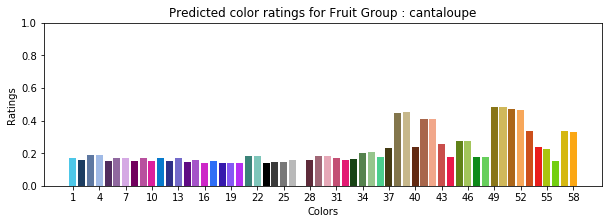

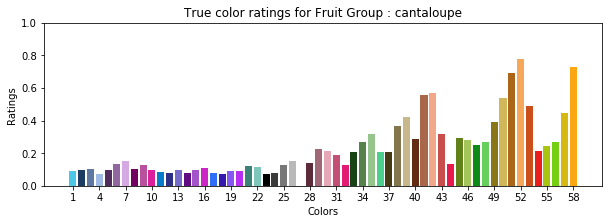

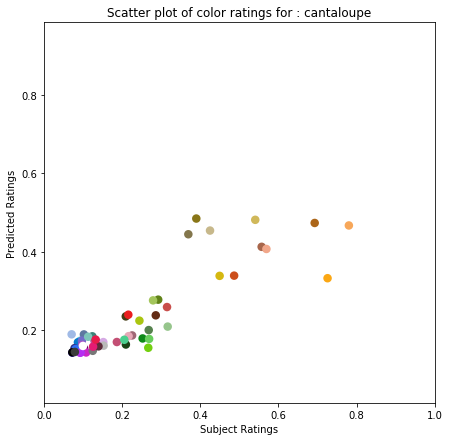


Leaving out fruit group :  grapefruit
Score is : 0.48
Coefficients:  [0.13864915 0.15649108 0.14352055 0.13366218]

Mean squared error: 0.0127
Variance score: 0.48

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8493


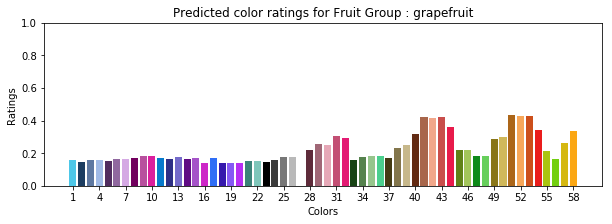

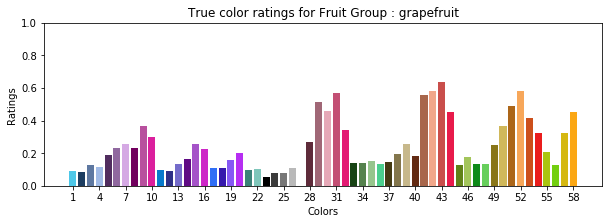

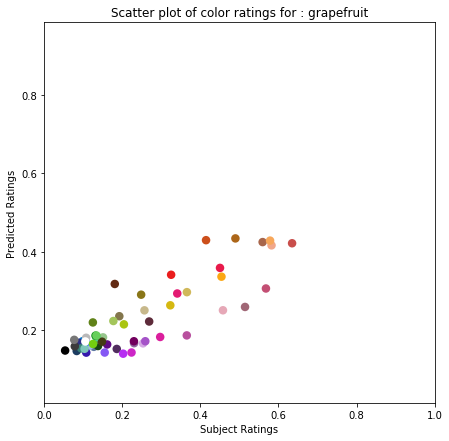


Leaving out fruit group :  strawberry
Score is : 0.15
Coefficients:  [0.13797353 0.1651715  0.12117494 0.15176156]

Mean squared error: 0.0231
Variance score: 0.15

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5249


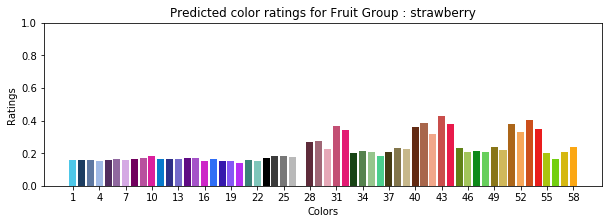

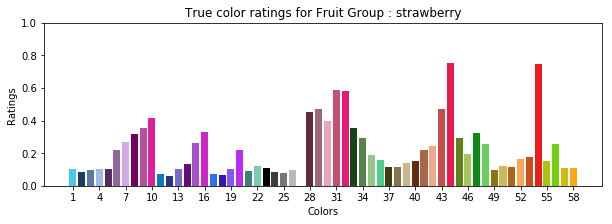

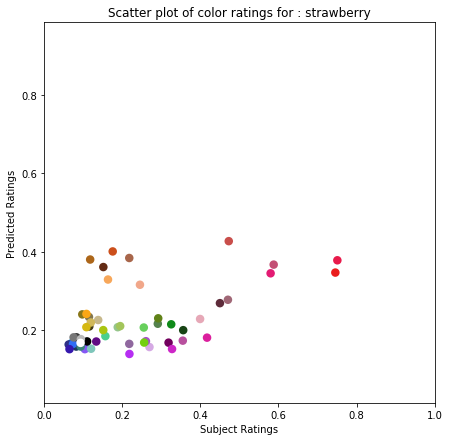


Leaving out fruit group :  raspberry
Score is : -0.04
Coefficients:  [0.136589   0.16701628 0.12575847 0.1533642 ]

Mean squared error: 0.0248
Variance score: -0.04

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4378


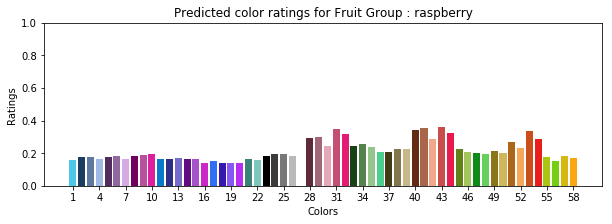

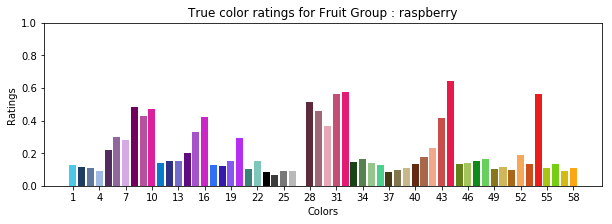

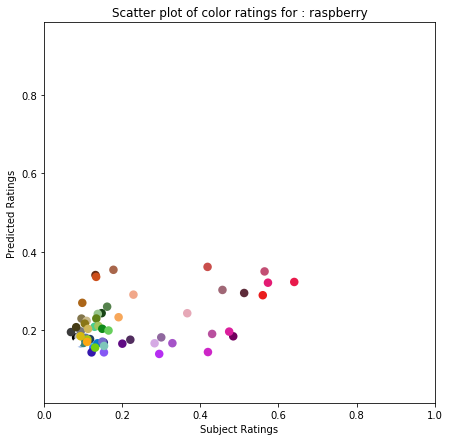


Leaving out fruit group :  blueberry
Score is : 0.12
Coefficients:  [0.13655055 0.16441624 0.12326751 0.14642162]

Mean squared error: 0.0374
Variance score: 0.12

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5479


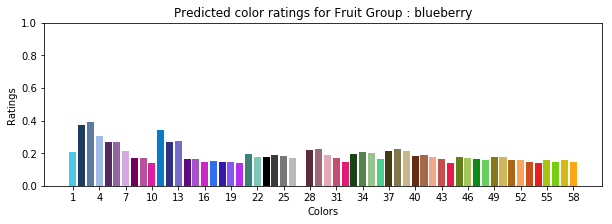

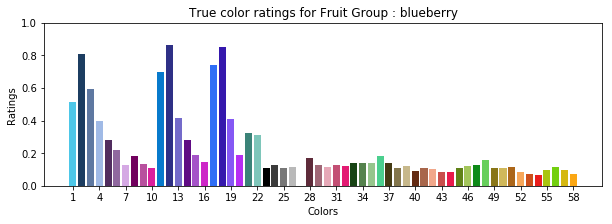

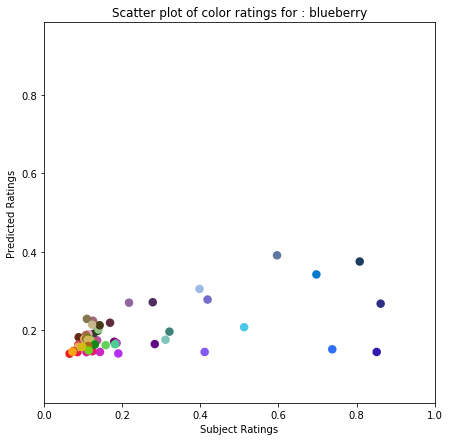


Leaving out fruit group :  avocado
Score is : 0.28
Coefficients:  [0.14192245 0.17760598 0.13423119 0.11917273]

Mean squared error: 0.0258
Variance score: 0.28

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6182


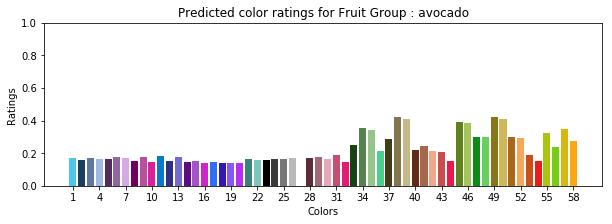

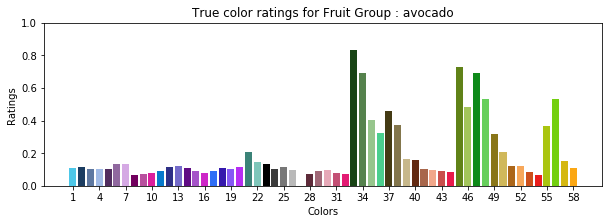

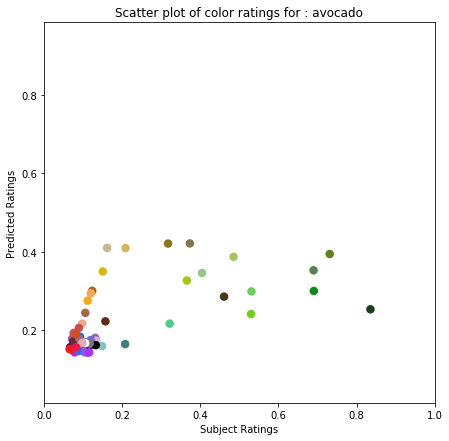


Leaving out fruit group :  orange
Score is : 0.56
Coefficients:  [0.14246284 0.18703348 0.0896108  0.13796074]

Mean squared error: 0.0163
Variance score: 0.56

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8930


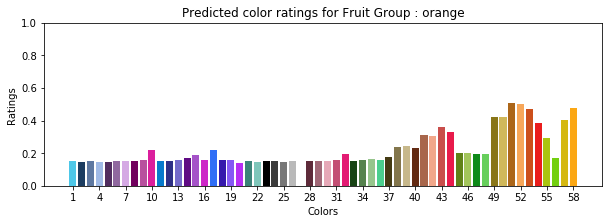

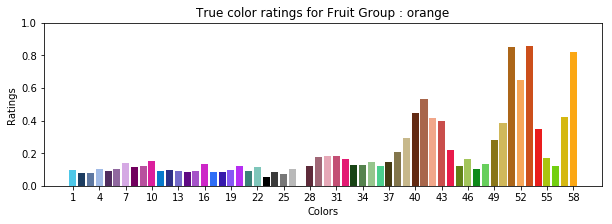

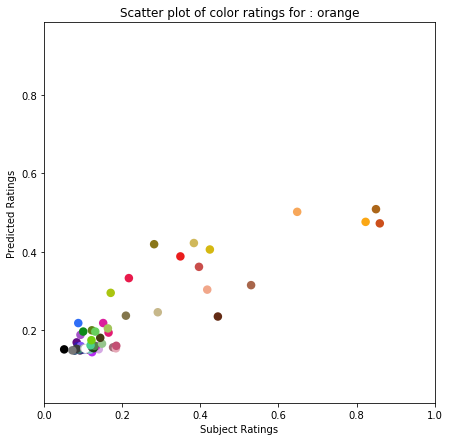


Leaving out fruit group :  lime
Score is : 0.42
Coefficients:  [0.14325166 0.18416779 0.10330547 0.13262631]

Mean squared error: 0.0255
Variance score: 0.42

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7716


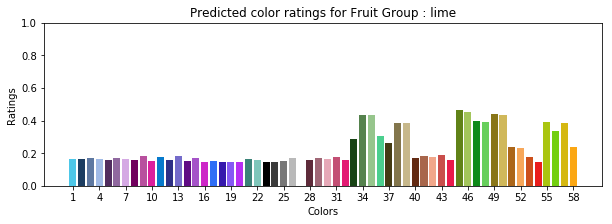

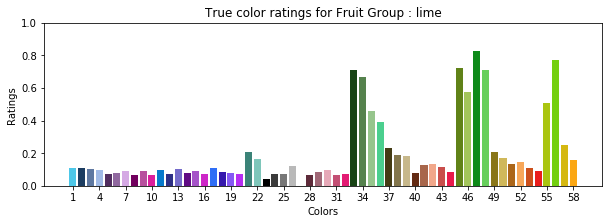

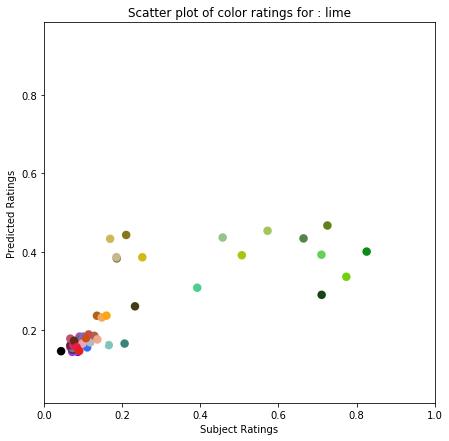


Leaving out fruit group :  lemon
Score is : 0.57
Coefficients:  [0.143261   0.17602643 0.10117005 0.14572475]

Mean squared error: 0.0112
Variance score: 0.57

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8887


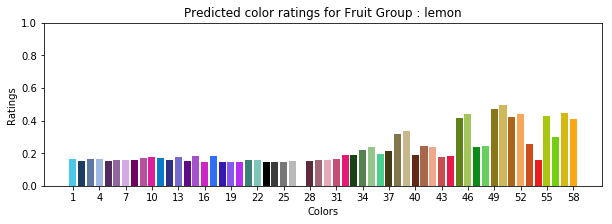

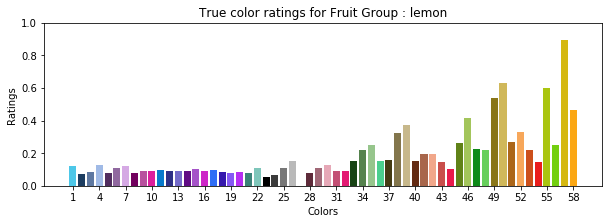

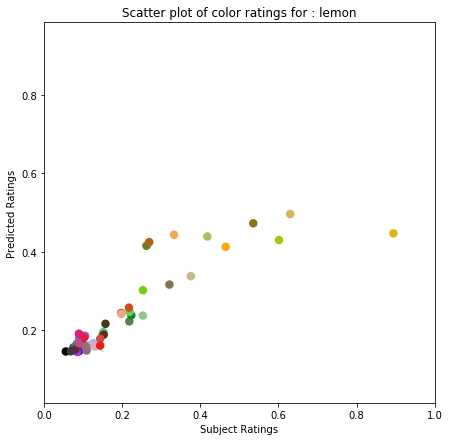

In [14]:
# Sparse features from Analysis II
minErrFeature2 = (54, 78, 179)
errSphCyl, corrSphCyl,  win0_m2, win1_m2, win2_m2 = getRatings(minErrFeature2)

# Regression on top 3 Spherical + Cylindrical + Categorical


Leaving out fruit group :  mango
Score is : 0.60
Coefficients:  [0.16997069 0.24922833 0.01446794 0.03916263]

Mean squared error: 0.0135
Variance score: 0.60

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9236


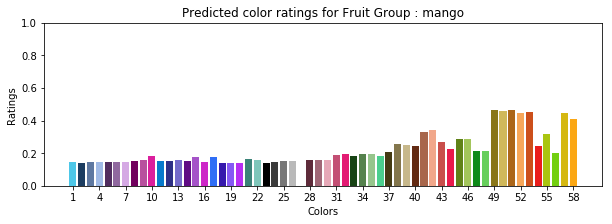

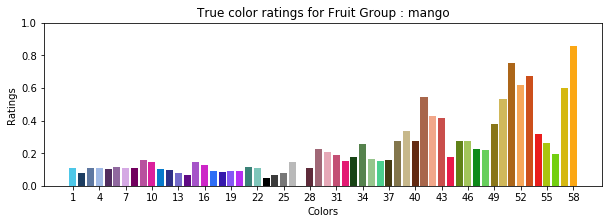

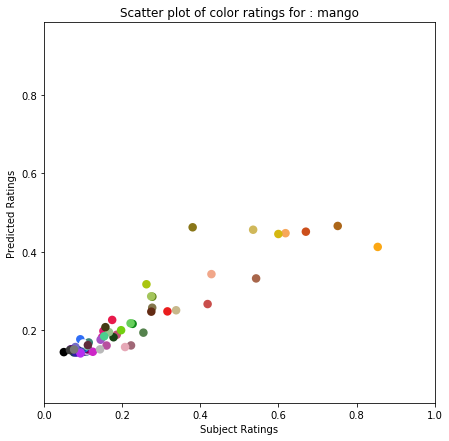


Leaving out fruit group :  watermelon
Score is : -0.00
Coefficients:  [0.1644369  0.26566246 0.02372788 0.03226191]

Mean squared error: 0.0368
Variance score: -0.00

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4705


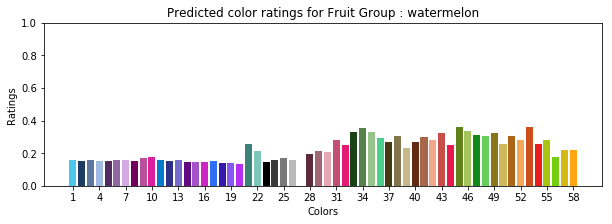

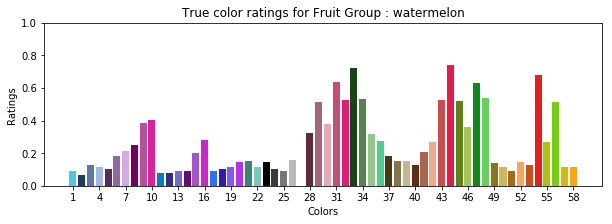

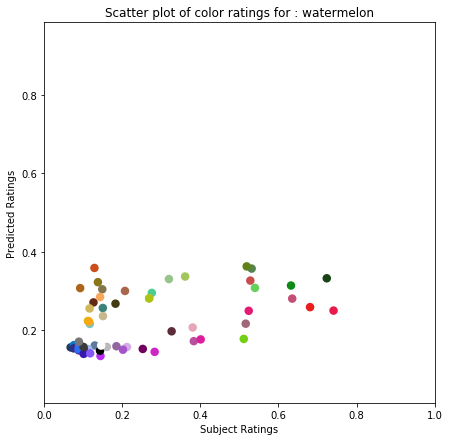


Leaving out fruit group :  honeydew
Score is : 0.51
Coefficients:  [0.16877061 0.26259882 0.02366663 0.03067353]

Mean squared error: 0.0098
Variance score: 0.51

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8724


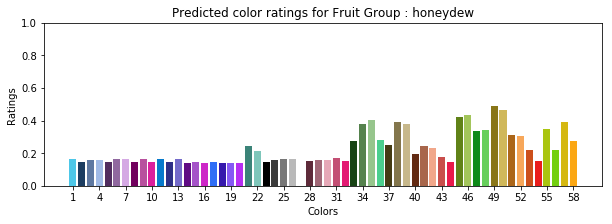

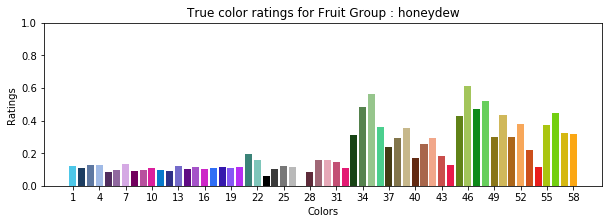

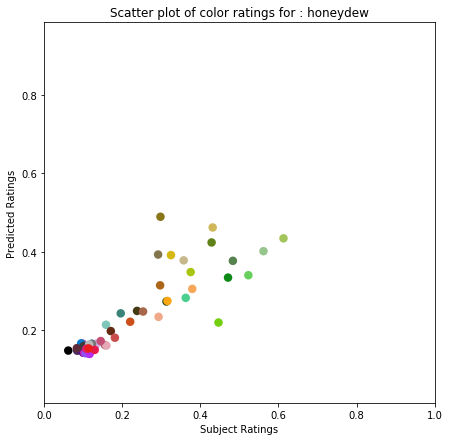


Leaving out fruit group :  cantaloupe
Score is : 0.63
Coefficients:  [0.16834301 0.25533087 0.01475232 0.03734693]

Mean squared error: 0.0117
Variance score: 0.63

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9293


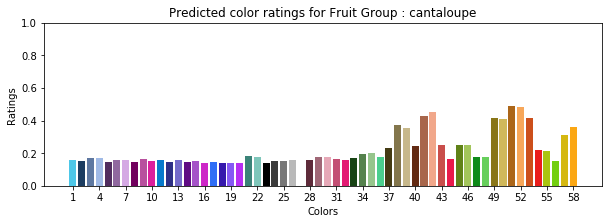

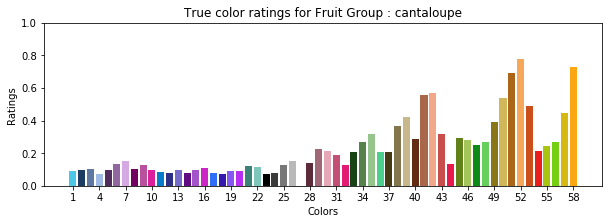

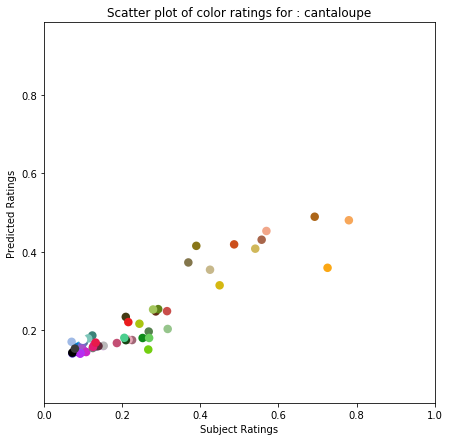


Leaving out fruit group :  grapefruit
Score is : 0.45
Coefficients:  [0.16713946 0.2568467  0.02164513 0.03354657]

Mean squared error: 0.0133
Variance score: 0.45

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8205


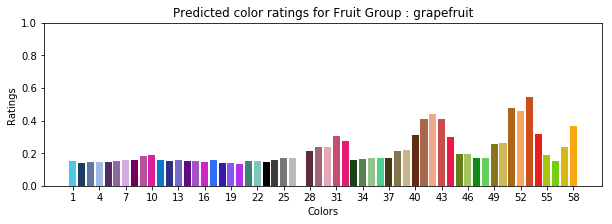

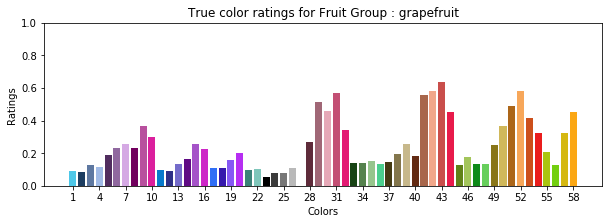

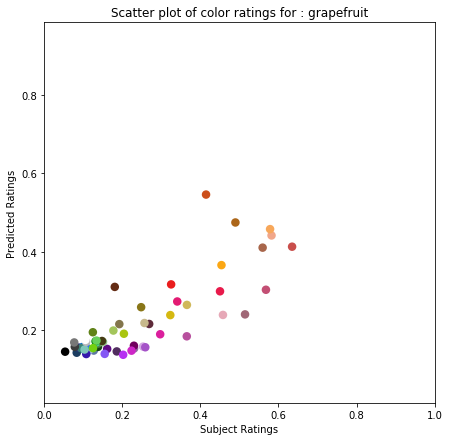


Leaving out fruit group :  strawberry
Score is : 0.08
Coefficients:  [0.16759064 0.26077299 0.0170599  0.03925091]

Mean squared error: 0.0250
Variance score: 0.08

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4594


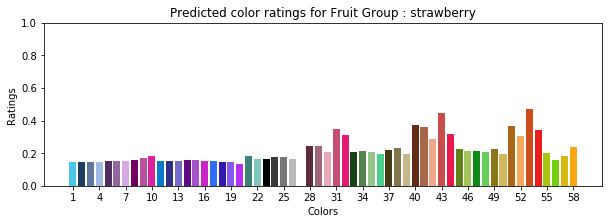

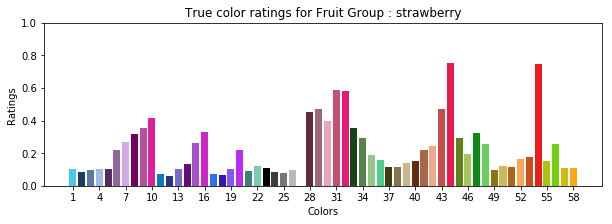

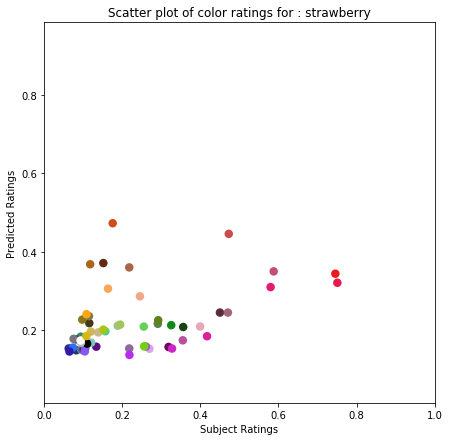


Leaving out fruit group :  raspberry
Score is : -0.11
Coefficients:  [0.16811908 0.26025123 0.01938423 0.03827357]

Mean squared error: 0.0265
Variance score: -0.11

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.2922


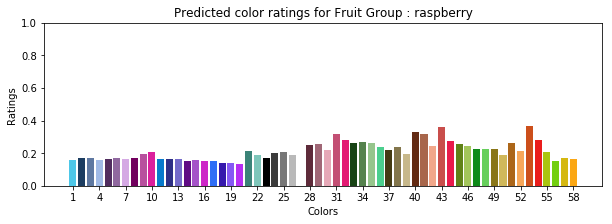

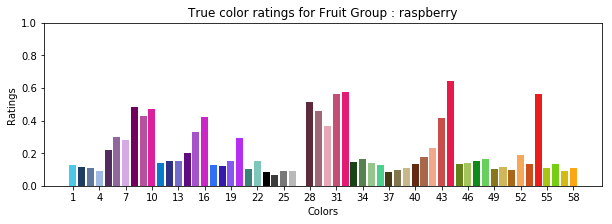

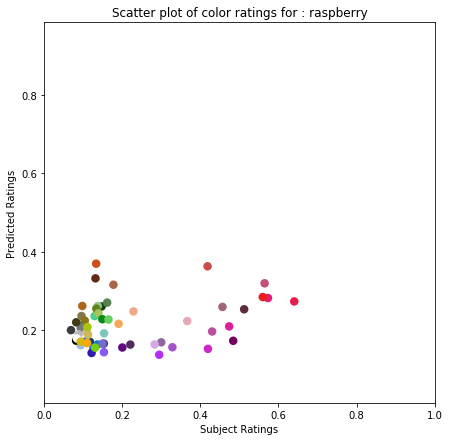


Leaving out fruit group :  blueberry
Score is : 0.24
Coefficients:  [0.16252414 0.28211467 0.00410554 0.04204887]

Mean squared error: 0.0323
Variance score: 0.24

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7265


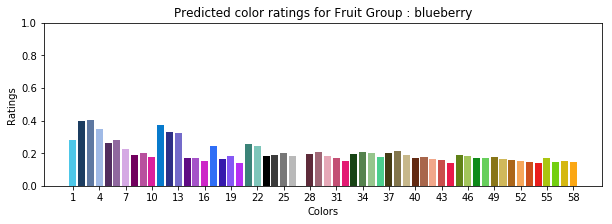

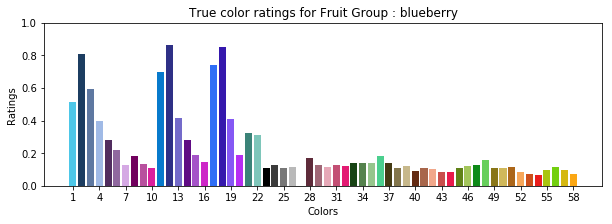

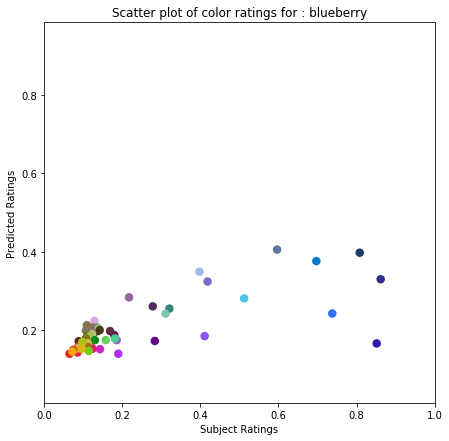


Leaving out fruit group :  avocado
Score is : 0.36
Coefficients:  [0.16861955 0.27016741 0.02920276 0.02019528]

Mean squared error: 0.0230
Variance score: 0.36

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7218


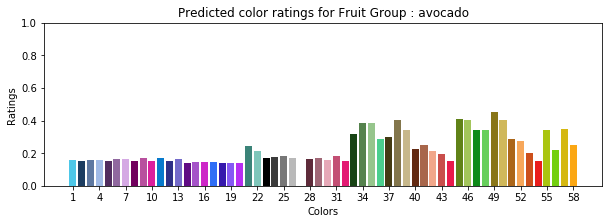

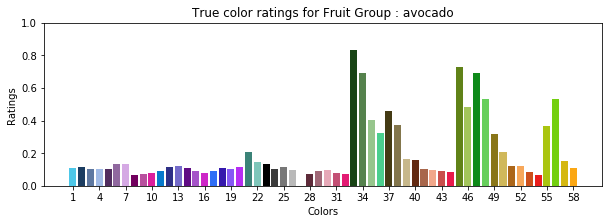

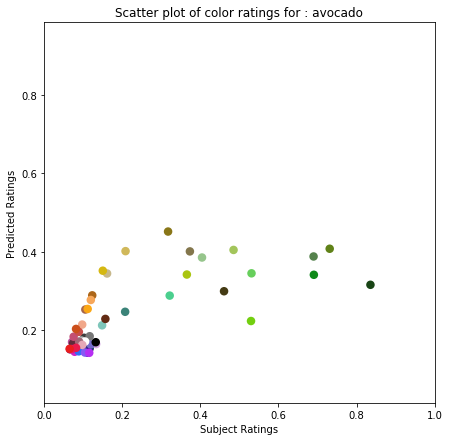


Leaving out fruit group :  orange
Score is : 0.69
Coefficients:  [0.16773559 0.26851134 0.01877639 0.02859073]

Mean squared error: 0.0116
Variance score: 0.69

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9500


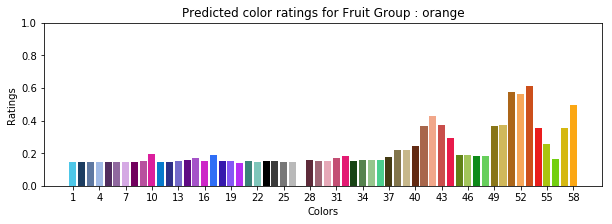

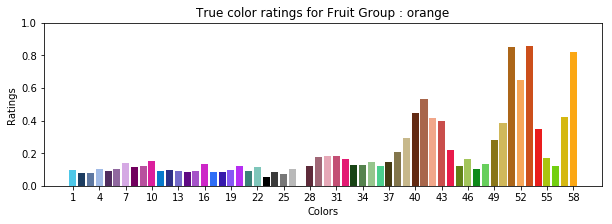

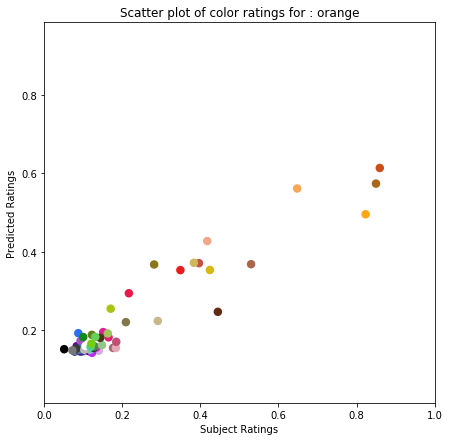


Leaving out fruit group :  lime
Score is : 0.50
Coefficients:  [0.16991305 0.26790927 0.0180716  0.03152807]

Mean squared error: 0.0219
Variance score: 0.50

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8329


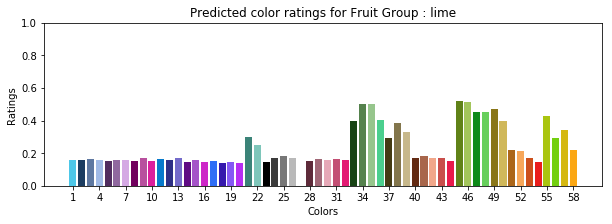

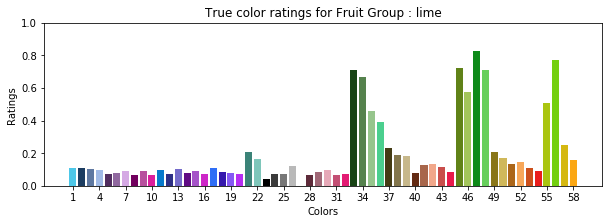

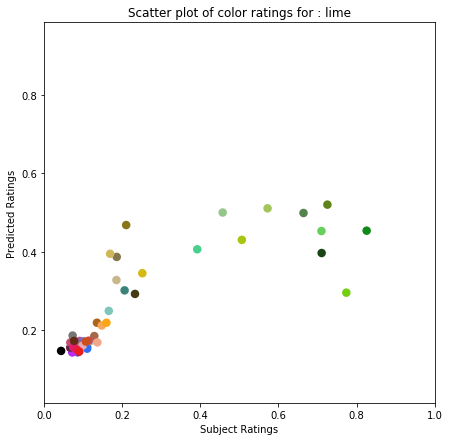


Leaving out fruit group :  lemon
Score is : 0.60
Coefficients:  [0.17131692 0.25823469 0.01163069 0.0411685 ]

Mean squared error: 0.0104
Variance score: 0.60

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9241


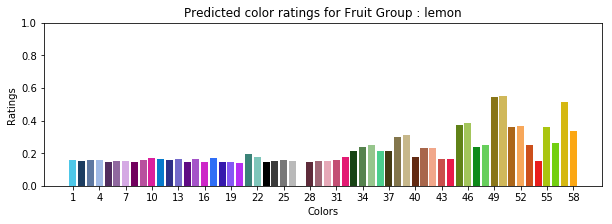

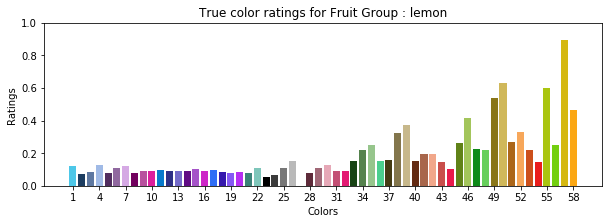

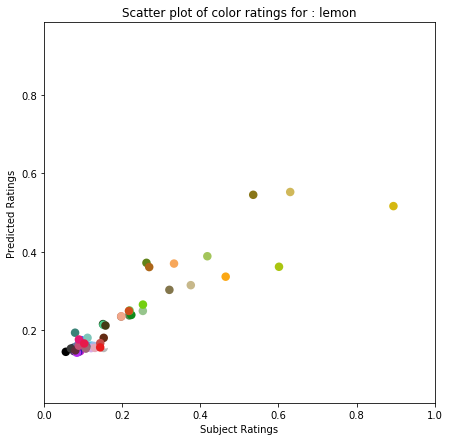

In [15]:
# Sparse features from Analysis III
minErrFeature3 = (54,186,187)  #(54, 179, 180)  # new : 55, 187, 188
errSphCylCat, corrSphCylCat,  win0_m3, win1_m3, win2_m3 = getRatings(minErrFeature3)

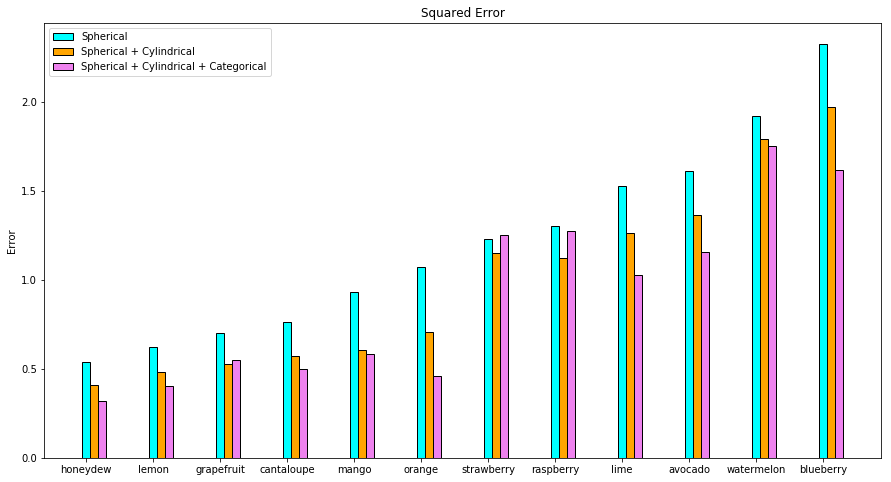

In [16]:
temp  = errSph[:]
indices = np.argsort(temp)
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize=(15,8))
plt.bar(r1,sorted(errSph),width = barWidth, color = 'cyan', edgecolor = 'black',label='Spherical')
plt.bar(r2,[errSphCyl[t] for t in indices],width = barWidth, color = 'orange', edgecolor = 'black',label='Spherical + Cylindrical')
plt.bar(r3,[errSphCylCat[t] for t in indices],width = barWidth, color = 'violet', edgecolor = 'black',label='Spherical + Cylindrical + Categorical')
plt.xticks(range(1,121,10),label)
plt.title("Squared Error")
plt.ylabel('Error')
plt.legend()
#plt.savefig('ErrWithIncreasingRadial.pdf')
plt.show()

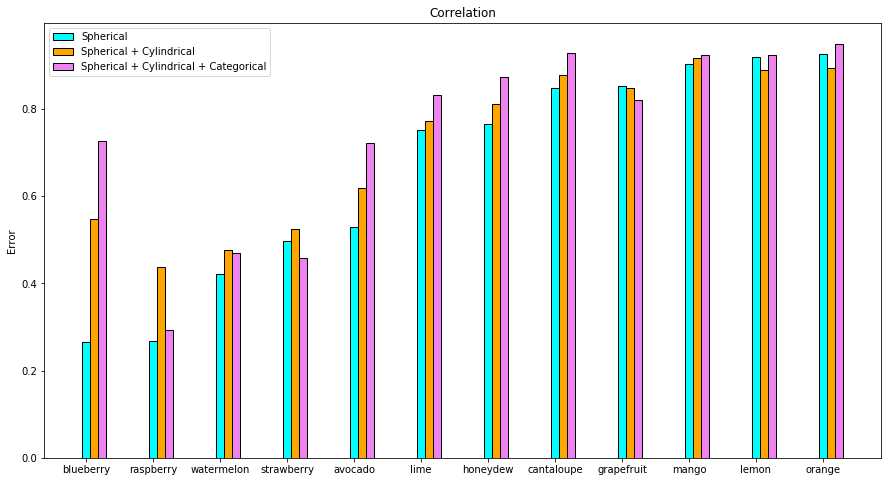

In [17]:
temp  = corrSph[:]
indices = np.argsort(temp)
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
plt.close('all')
#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize=(15,8))
plt.bar(r1,sorted(corrSph),width = barWidth, color = 'cyan', edgecolor = 'black',label='Spherical')
plt.bar(r2,[corrSphCyl[t] for t in indices],width = barWidth, color = 'orange', edgecolor = 'black',label='Spherical + Cylindrical')
plt.bar(r3,[corrSphCylCat[t] for t in indices],width = barWidth, color = 'violet', edgecolor = 'black',label='Spherical + Cylindrical + Categorical')
plt.xticks(range(1,121,10),label)
plt.title("Correlation")
plt.ylabel('Error')
plt.legend()
#plt.savefig('CorrWithIncreasingRadial.eps')
plt.show()

In [18]:
# # For plots of correlations
# err, corr, win0, win1, win2 = getRatings(minErrFeature3, True)

# Figure2: Scatter plots for the best model

In [19]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 9})
def createScatterPlots(indices, win0, win1, win2,model_num):
    print("----------------------- Creating plots for Model ---------------",model_num)
    # print(indices)
    # print(win0)
    
    k = 1
    plt.close('all')

    plt.subplots(3,4,figsize=(10,10))
    for i in range(len(indices)-1,-1,-1):
        # Scatter plot

        arg = indices[i]
        trueRating = win1[arg]
        avg_pred = win2[arg]

        ax = plt.subplot(3,4,k,aspect='equal') #plt.figure(figsize=(7,7))
        #ax = f.add_subplot(3,4,k)
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
        if k == 1 or k == 5 or k == 9:
            plt.ylabel('Mean Predicted Rating')
        plt.xlabel('Mean Rating')
        s = allConcepts[arg]+"( %.2f )" %win0[arg]
        #print(s)
        plt.title(s)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.yticks([0,0.5,1])
        plt.xticks([0,0.5,1])
        plt.tick_params(direction='in')
        plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
        k = k+1
    plotName = "Top50_ScatterPlot_Model_"+str(model_num)+".pdf"
    #plt.savefig(plotName)
    plt.show()
    
    

----------------------- Creating plots for Model --------------- 1


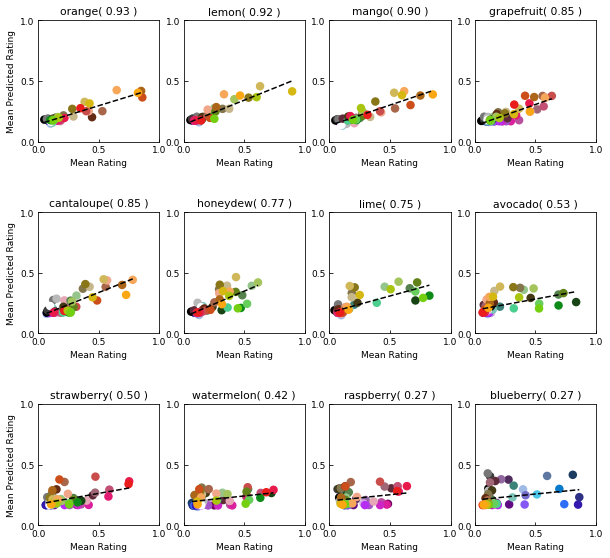

----------------------- Creating plots for Model --------------- 2


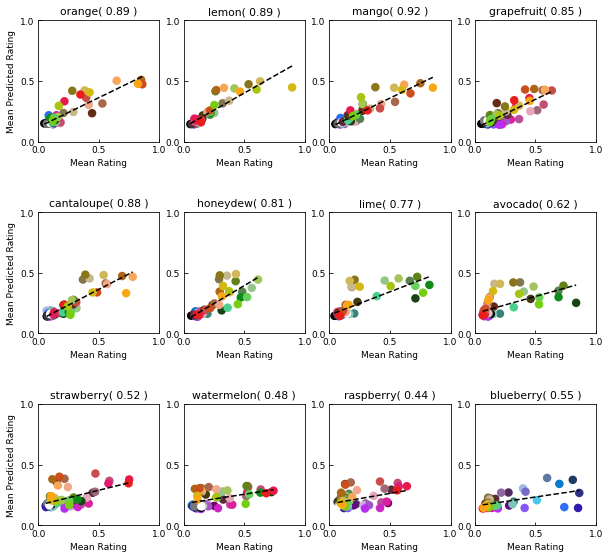

----------------------- Creating plots for Model --------------- 3


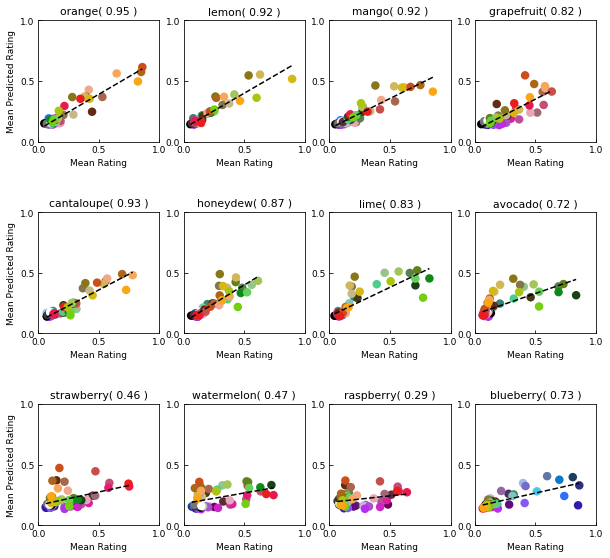

In [20]:
indices = np.argsort(win0_m1) # Want in the order of model 1 correlations
createScatterPlots(indices, win0_m1, win1_m1, win2_m1,1)
createScatterPlots(indices, win0_m2, win1_m2, win2_m2,2)
createScatterPlots(indices,win0_m3, win1_m3, win2_m3,3)

In [21]:
# indices = np.argsort(win0_m3)
# print(indices)
# print(win0_m3)

In [22]:
# k = 1
# plt.close('all')
# import matplotlib as mpl
# mpl.rcParams.update({'font.size': 9})
# plt.subplots(3,4,figsize=(10,10))
# for i in range(len(indices)-1,-1,-1):
#     # Scatter plot
    
#     arg = indices[i]
#     trueRating = win1_m3[arg]
#     avg_pred = win2_m3[arg]
    
#     ax = plt.subplot(3,4,k,aspect='equal') #plt.figure(figsize=(7,7))
#     #ax = f.add_subplot(3,4,k)
#     plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
#     if k == 1 or k == 5 or k == 9:
#         plt.ylabel('Mean Predicted Rating')
#     plt.xlabel('Mean Rating')
#     s = allConcepts[arg]+"( %.2f )" %win0_m3[arg]
#     #print(s)
#     plt.title(s)
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.yticks([0,0.5,1])
#     plt.xticks([0,0.5,1])
#     plt.tick_params(direction='in')
#     plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
#     k = k+1
# plt.savefig('ScatterPlotBestModel.pdf')
# plt.show()

In [23]:
cor_m3,_ = stats.pearsonr(np.array(win2_m3).flatten(), np.array(win1_m3).flatten())
cor_m2,_ = stats.pearsonr(np.array(win2_m2).flatten(), np.array(win1_m2).flatten())
cor_m1,_ = stats.pearsonr(np.array(win2_m1).flatten(), np.array(win1_m1).flatten())

In [24]:
print("For TOP 50")
print("model 1:", cor_m1)
print("model 2:",cor_m2)
print("model :3",cor_m3)


For TOP 50
model 1: 0.6493732237783579
model 2: 0.7169030733557531
model :3 0.7539504231277306


In [25]:
[cor_m1, cor_m2, cor_m3]

[0.6493732237783579, 0.7169030733557531, 0.7539504231277306]

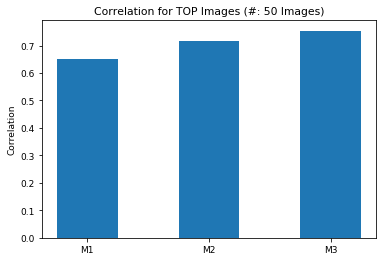

In [26]:
barWidth = 0.5
plt.bar(range(1,4),[cor_m1, cor_m2, cor_m3], width = barWidth)
plt.xticks(range(1,4),['M1','M2','M3'])
plt.title("Correlation for TOP Images (#: 50 Images)")
plt.ylabel('Correlation')
plt.show()

# Figure 3: Error and Correlation stem plots for #Images: 50

In [27]:
# temp  = errSph
# print(np.argsort(temp))
# indices = np.flipud(np.argsort(temp))
# indices

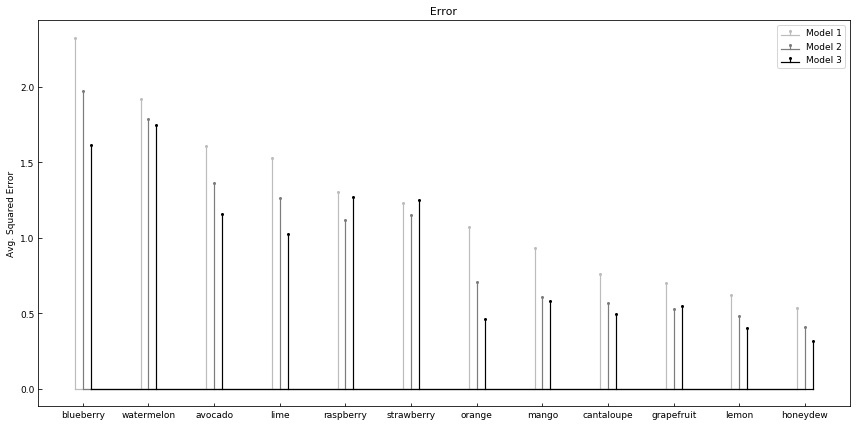

In [28]:
plt.close('all')
temp  = errSph[:]
indices = np.flipud(np.argsort(temp)) # Sort and get indices and reverse order
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize =(12,6))#(7,1.5)) # 
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
mline1 = plt.stem(r1,sorted(errSph)[::-1], linefmt='-',label='Model 1')
plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.2, markersize = 2)
#plt.setp(sline1, linewidth=0.8)


mline2 = plt.stem(r2,[errSphCyl[t] for t in indices],label='Model 2')
plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.2, markersize = 2)

mline3 = plt.stem(r3,[errSphCylCat[t] for t in indices],label='Model 3')
plt.setp(mline3, color=[0,0,0], linewidth=1.2, markersize = 2)

plt.xticks(r2,label)
plt.tick_params(direction='in')
plt.title("Error")
plt.ylabel('Avg. Squared Error')
plt.legend()
plt.tight_layout()
#plt.savefig('ErrorTop50_AllModels.pdf')
plt.show()

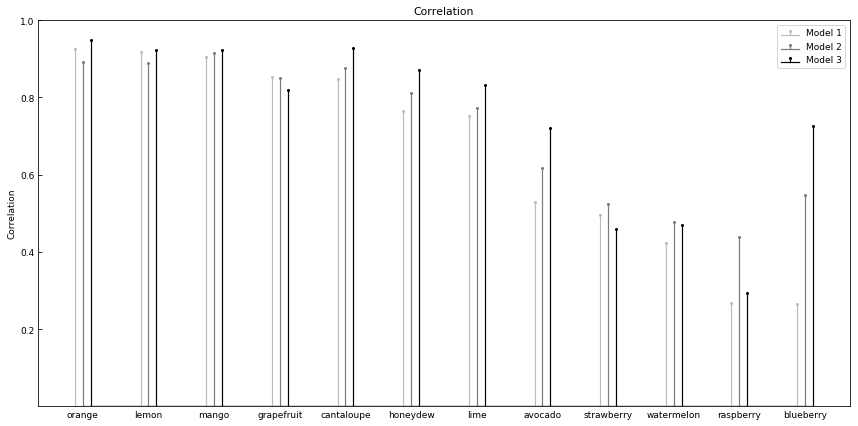

In [29]:
plt.close('all')
temp  = corrSph[:]
indices = np.flipud(np.argsort(temp)) # Sort and get indices and reverse order
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

fig = plt.figure(figsize =(12,6))
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
mline1 = plt.stem(r1,sorted(corrSph)[::-1], linefmt='-',label='Model 1')
plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.2, markersize = 2)

mline2 = plt.stem(r2,[corrSphCyl[t] for t in indices],label='Model 2')
plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.2, markersize = 2)

mline3 = plt.stem(r3,[corrSphCylCat[t] for t in indices],label='Model 3')
plt.setp(mline3, color=[0,0,0], linewidth=1.2, markersize = 2)

plt.xticks(r2,label)
plt.yticks([0.2, 0.4,0.6, 0.8, 1])
plt.tick_params(direction='in')
plt.title("Correlation")
plt.ylabel('Correlation')
plt.legend()
plt.ylim(0,1)

plt.tight_layout() 
#plt.savefig('CorrelationTop50_AllModels.pdf')
plt.show()

# Plot for Lemon Lime Blueberry

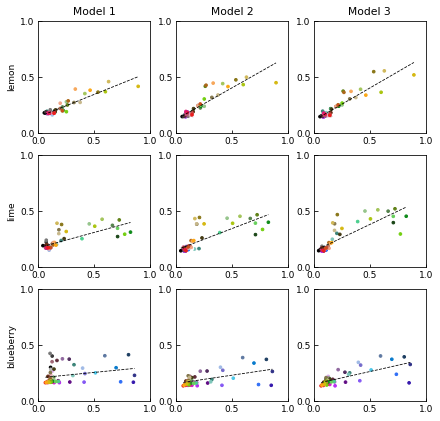

In [30]:
allConcepts = ['mango','watermelon','honeydew','cantaloupe','grapefruit','strawberry','raspberry','blueberry','avocado','orange','lime','lemon']
ind1 = 11 #Lemon
ind2 = 10 # Lime
ind3 = 7 # Blueberry
plt.close('all')
k = 1
title = ['Model 1', 'Model 2', 'Model 3']
plt.subplots(3,3,figsize=(7,7))
for i in range(3):
    # Scatter plot
    if i == 0:
        ind = 11
    elif i == 1:
        ind = 10
    else:
        ind = 7
    
    for j in range(3):
        if j == 0:
            trueRating = np.copy(win1_m1[ind])
            avg_pred =np.copy( win2_m1[ind])
        elif j == 1:
            trueRating = np.copy(win1_m2[ind])
            avg_pred = np.copy(win2_m2[ind])
        else:
            trueRating = np.copy(win1_m3[ind])
            avg_pred = np.copy(win2_m3[ind])

        ax = plt.subplot(3,3,k,aspect='equal') #plt.figure(figsize=(7,7))
        plt.scatter(trueRating, avg_pred,c=colorDataRGB.values,marker = 'o',s = 7)
        if k == 1 or k == 4 or k == 7:
            plt.ylabel(allConcepts[ind])
#         plt.xlabel('Mean Rating')
    #     s = allConcepts[arg]+"( %.2f )" %win0[arg]
    #     #print(s)
    #     plt.title(s)
        if k in [1,2,3]:
            plt.title(title[k-1])
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.yticks([0,0.5,1])
        plt.xticks([0,0.5,1])
        plt.tick_params(direction='in')
        plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--',linewidth=0.8)
        k = k+1
#plt.tight_layout() 
#plt.savefig('LemonLimeBlueberry_ScatterPlotTop50.pdf')
plt.show()

In [31]:
print(np.mean(errSph))
print(np.mean(errSphCyl))
print(np.mean(errSphCylCat))

1.2115496285699254
0.9967443550802585
0.907315000949206


In [32]:
print(errSph)

[0.9298740034723045, 1.9182300358542779, 0.5378211634232704, 0.7624833019725957, 0.6996933452773714, 1.2276752571278013, 1.302135733768031, 2.3255004746674155, 1.6104019663759899, 1.0740603295819162, 1.526278902065123, 0.6244410292530058]
